In [1]:
import cv2
import torch
import torchvision
import numpy as np
import utils

import matplotlib.pyplot as plt

import torchvision.transforms.functional

In [2]:
img = np.array(cv2.imread('images/castle.jpg'))[...,::-1]/255.0

# values from https://pytorch.org/vision/main/models/generated/torchvision.models.vgg16.html
mean = torch.Tensor([0.485, 0.456, 0.406]).reshape(1,-1,1,1)
std  = torch.Tensor([0.229, 0.224, 0.225]).reshape(1,-1,1,1)

X = (torch.FloatTensor(img[np.newaxis].transpose([0,3,1,2])*1) - mean) / std
Xnp = X.detach().cpu().numpy()

In [3]:
# loading the model
model = torchvision.models.vgg16(pretrained=True)
model.eval()

# extraction of the layers
layers = list(model._modules['features']) + utils.toconv(list(model._modules['classifier']))
L = len(layers)

/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
# activations for each layer
A = [X]+[None]*L
for l in range(L):
    A[l+1] = layers[l].forward(A[l])
T = torch.FloatTensor((1.0*(np.arange(1000)==483).reshape([1,1000,1,1])))

In [5]:
manual_thetas = {
    0: .05,
    2: .05,
    5: .05,
    7: .05,
    10: .05,
    12: .05,
    14: .06,
    17: .06,
    19: .06,
    21: .1,
    24: .09,
    26: .025,
    28: .3,
    31: .043,
    34: .0145,
    37: .0145
}

In [18]:
conv_indices = [l for l in range(0, 37+1) if type(layers[l]).__name__ == "Conv2d"]

ksize = np.array([layers[l].kernel_size[0] for l in range(0, 37+1) if type(layers[l]).__name__ == "Conv2d"])
shapes = np.array([A[l].shape[3] for l in range(0, 37+1) if type(layers[l]).__name__ == "Conv2d"])

slided_ksize = np.concatenate((ksize[1:], np.array([ksize[-1]])))

theta_0 = 0.005
epsilon_0 = 0.0066

division = theta_0 * (slided_ksize**2 + 3*np.log(shapes)) + epsilon_0 + 0.0002*(np.arange(16))
#theta_0 * slided_ksize**2/(epsilon_0 + np.sqrt(shapes))

thetas = {}
for i, l in enumerate(conv_indices):
 thetas[l] = division[i]

thetas

{0: 0.13277469077782558,
 2: 0.1329746907778256,
 5: 0.12277748306942642,
 7: 0.12297748306942642,
 10: 0.11278027536102724,
 12: 0.11298027536102724,
 14: 0.11318027536102725,
 17: 0.10298306765262805,
 19: 0.10318306765262805,
 21: 0.10338306765262804,
 24: 0.09318585994422886,
 26: 0.09338585994422885,
 28: 0.29358585994422887,
 31: 0.043388652235829696,
 34: 0.0144,
 37: 0.014599999999999998}

In [35]:
print(np.corrcoef(list(manual_thetas.values()), slided_ksize)[0,1])
print(np.corrcoef(list(manual_thetas.values()), ksize)[0,1])

0.8812650374800106
0.09082772978158843


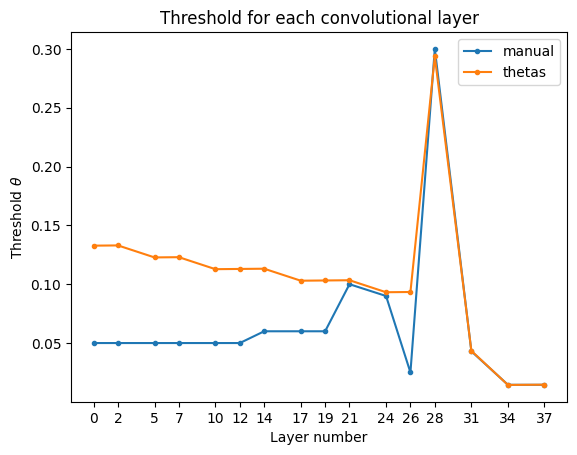

In [28]:
plt.plot(list(thetas), list(manual_thetas.values()), label="manual", marker=".")
plt.plot(list(thetas), list(thetas.values()), label="thetas", marker=".")

plt.xlabel("Layer number")
plt.xticks(list(thetas))
plt.ylabel("Threshold $\\theta$")
plt.title("Threshold for each convolutional layer")
plt.legend()
plt.show()

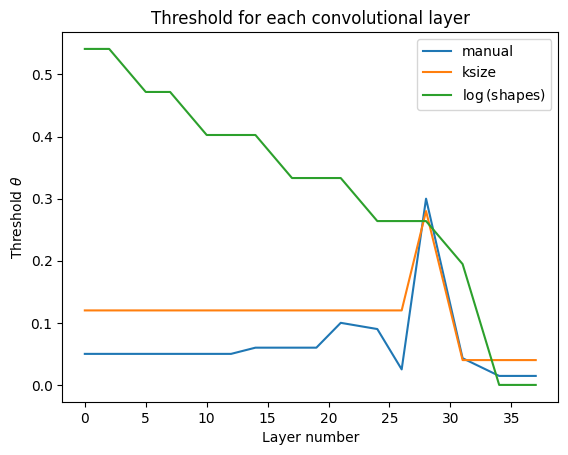

In [27]:
plt.plot(list(thetas), list(manual_thetas.values()), label="manual")
#plt.plot(list(thetas), list(thetas.values()), label="thetas")

plt.plot(list(thetas), np.concatenate((ksize[1:], np.array([ksize[-1]]), ))/25, label="ksize")
plt.plot(list(thetas), np.log(shapes)/10, label="$\log$(shapes)")

plt.xlabel("Layer number")
plt.ylabel("Threshold $\\theta$")
plt.title("Threshold for each convolutional layer")
plt.legend()
plt.show()